## 4- Baseline modeling experiment 2 - XGBoost model
* Using baseline dataset.
* Grid search will be applied to find the best-performing hyperparameter combination.
    * Model will be __fit__ on the __train__ set.
    * The __validation__ set will be used to pick the best-performing hyperparameter combination (via PredefinedSplit).
    * Final evaluation will be done on the __test__ set.
    * When using Predefined Split, the refit parameter for GridSearchCV has to be False in order for scoring to happen on df_val records.
        * When refit is False, the GridSearchCV.best_estimator_ model object is not available .
        * As such, a final fit will occur on the best-peforming hyperparameters on the train set only to get the final model.

#### Stages
1. __Reading data__.
2. __Preparing data__.
3. __Grid search model training__.
4. **Fitting model on best parameters (cv.best_estimator_ not available)**.
5. __Model evaluation__.
6. __Feature importances__.
7. __Saving model__.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold  # for splitting into train/val/test based on customer id while keeping fraud ratio the same for the three sets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    average_precision_score, 
    confusion_matrix, 
    classification_report
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
RANDOM_SEED = 420

### 1- Reading data

In [3]:
train_df = pd.read_csv("data/train_baseline.csv")
val_df = pd.read_csv("data/validation_baseline.csv")
test_df = pd.read_csv("data/test_baseline.csv")

In [4]:
train_df.shape

(476608, 30)

In [5]:
train_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.303248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,0.018468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.098661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.186943,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,-0.017797,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [6]:
val_df.shape

(60291, 30)

In [7]:
val_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.020728,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.168078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.071645,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.234106,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.622063,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
test_df.shape

(57744, 30)

In [9]:
test_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.048201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.068440,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.184287,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,0.027718,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.457954,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


### 2- Preparing data

In [10]:
target_column = "fraud"

In [11]:
feature_columns = [column for column in train_df.columns if column != target_column]

In [12]:
feature_columns

['step',
 'amount',
 'age_0',
 'age_1',
 'age_2',
 'age_3',
 'age_4',
 'age_5',
 'age_6',
 'age_U',
 'gender_E',
 'gender_F',
 'gender_M',
 'gender_U',
 'category_es_barsandrestaurants',
 'category_es_contents',
 'category_es_fashion',
 'category_es_food',
 'category_es_health',
 'category_es_home',
 'category_es_hotelservices',
 'category_es_hyper',
 'category_es_leisure',
 'category_es_otherservices',
 'category_es_sportsandtoys',
 'category_es_tech',
 'category_es_transportation',
 'category_es_travel',
 'category_es_wellnessandbeauty']

In [13]:
X_train = train_df[feature_columns].copy()
y_train = train_df[target_column].astype(int).copy()

In [14]:
X_val = val_df[feature_columns].copy()
y_val = val_df[target_column].astype(int).copy()

In [15]:
X_test = test_df[feature_columns].copy()
y_test = test_df[target_column].astype(int).copy()

In [16]:
# Combine train and val (PredefinedSplit for specifying the val set indices as the validation set for GridSearchCV)
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)

In [17]:
# mark df_val rows as the single validation fold
test_fold = np.r_[
    -1 * np.ones(len(X_train), dtype=int),  # -1 => always train
     0 * np.ones(len(X_val),   dtype=int)  #  0 => the held-out validation fold
]

In [18]:
predefined_split = PredefinedSplit(test_fold)

In [19]:
print("PredefinedSplit sizes -> train:", (test_fold == -1).sum(), " val:", (test_fold == 0).sum())

PredefinedSplit sizes -> train: 476608  val: 60291


### 3- Grid search model training

In [20]:
# Calculating scale_post_weight to add to model param grid
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_post_weight = (neg / max(pos, 1)) if pos > 0 else 1.0
print(f"scale_pos_weight (train): {scale_post_weight:.2f}")

scale_pos_weight (train): 83.66


In [21]:
model = XGBClassifier()

In [22]:
param_grid = {
    "random_state": [RANDOM_SEED],
    "n_estimators": [100, 300],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "scale_pos_weight": [None, scale_post_weight]
}

In [23]:
# Number of combinations
pg = ParameterGrid(param_grid)
print(f"Number of combinations: {len(pg)}")

Number of combinations: 36


In [24]:
cv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1",
    cv=predefined_split, # use df_val as the single validation fold
    n_jobs=-1, # Use all cpus
    refit=False
)

In [25]:
%%time

cv.fit(X, y)

/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: 

CPU times: user 328 ms, sys: 177 ms, total: 505 ms
Wall time: 40.6 s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.05, 0.1, ...], 'max_depth': [4, 6, ...], 'n_estimators': [100, 300], 'random_state': [420], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,False
,cv,"PredefinedSpl......, 0, 0]))"
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [26]:
print(f"Best parameters: {cv.best_params_}")

Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'random_state': 420, 'scale_pos_weight': None}


In [27]:
print(f"f1-score of best parameters: {cv.cv_results_["mean_test_score"][cv.best_index_]}")

f1-score of best parameters: 0.7218390804597701


### 4- Fitting model on best parameters (cv.best_estimator_ not available)

In [28]:
model = XGBClassifier(n_jobs=-1).set_params(**cv.best_params_)

In [29]:
model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [30]:
%%time

model.fit(X_train, y_train)

CPU times: user 21.4 s, sys: 71 ms, total: 21.5 s
Wall time: 1.42 s


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [31]:
model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### 5- Model evaluation

In [32]:
def evaluate_model(model, X, y, name="model"):
    # predictions
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
    else:
        scores = model.predict(X)
        
    preds = (scores >= 0.5).astype(int)

    # metrics
    metrics = {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0),
        "f1": f1_score(y, preds, zero_division=0),
        "roc_auc": roc_auc_score(y, scores) if len(np.unique(y)) > 1 else np.nan,
        "avg_precision": average_precision_score(y, scores),
        "classification_report": classification_report(y, preds, digits=3)
    }
    print(f"\n{name} — metrics\n")
    for k in ["accuracy", "precision", "recall", "f1", "roc_auc", "avg_precision"]:
        v = metrics[k]
        print(f"{k:>14}: {v:.4f}" if v==v else f"{k:>14}: nan")
    print("\nClassification report:\n", metrics["classification_report"])
    
    # confusion matrix
    cm = confusion_matrix(y, preds, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        fmt="d",
        cbar=True,
        annot=True,
        xticklabels=("Non_Fraudulent", "Fraudulent"),
        yticklabels=("Non_Fraudulent", "Fraudulent"),
        ax=ax,
        cmap="cividis"
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()
    return metrics

#### 5.1- Evaluation on validation set


Baseline Experiment - XGBoost Validation Set — metrics

      accuracy: 0.9960
     precision: 0.8579
        recall: 0.6230
            f1: 0.7218
       roc_auc: 0.9899
 avg_precision: 0.7877

Classification report:
               precision    recall  f1-score   support

           0      0.997     0.999     0.998     59787
           1      0.858     0.623     0.722       504

    accuracy                          0.996     60291
   macro avg      0.927     0.811     0.860     60291
weighted avg      0.996     0.996     0.996     60291



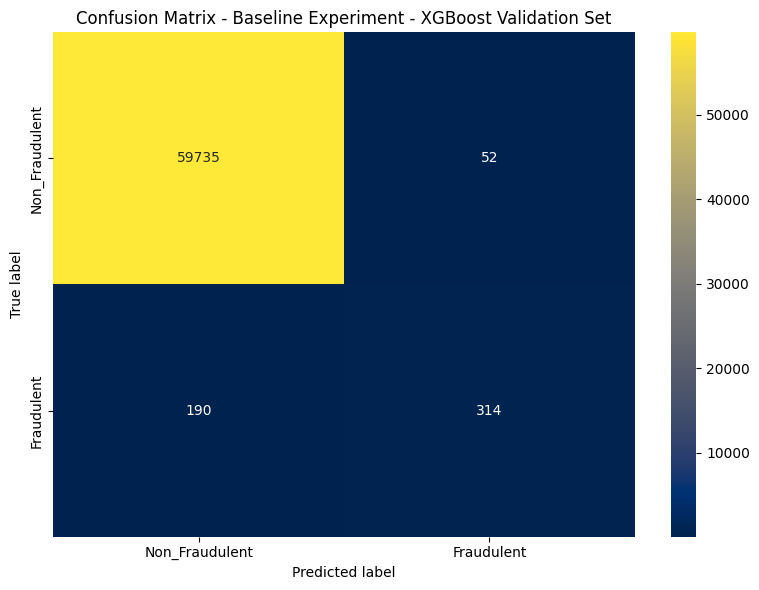

CPU times: user 593 ms, sys: 8.43 ms, total: 601 ms
Wall time: 216 ms


In [33]:
%%time

metrics = evaluate_model(
    model=model,
    X=X_val,
    y=y_val,
    name="Baseline Experiment - XGBoost Validation Set"
)

#### 5.2- Evaluation on test set


Baseline Experiment - XGBoost Test Set — metrics

      accuracy: 0.9917
     precision: 0.9153
        recall: 0.6079
            f1: 0.7306
       roc_auc: 0.9810
 avg_precision: 0.8253

Classification report:
               precision    recall  f1-score   support

           0      0.993     0.999     0.996     56678
           1      0.915     0.608     0.731      1066

    accuracy                          0.992     57744
   macro avg      0.954     0.803     0.863     57744
weighted avg      0.991     0.992     0.991     57744



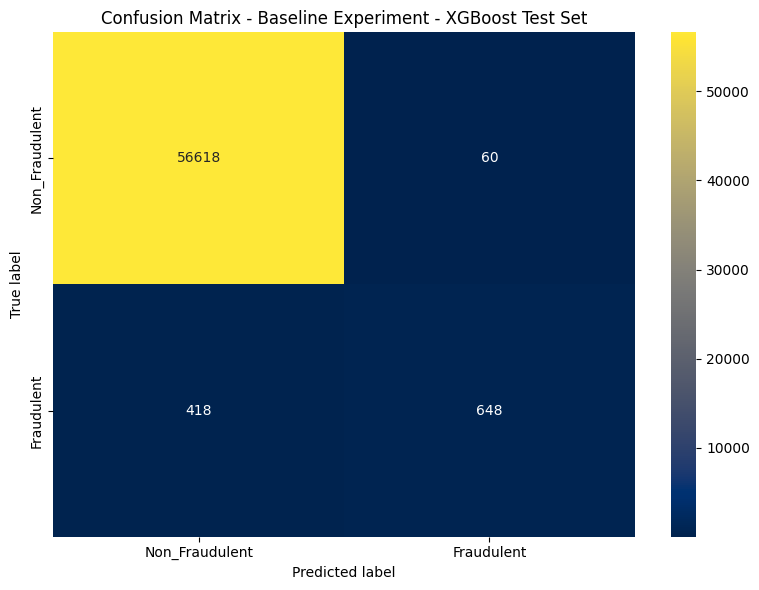

CPU times: user 585 ms, sys: 0 ns, total: 585 ms
Wall time: 162 ms


In [34]:
%%time

metrics = evaluate_model(
    model=model,
    X=X_test,
    y=y_test,
    name="Baseline Experiment - XGBoost Test Set"
)

### 6- Feature importances

In [35]:
# Gain feature importances
feature_importances = pd.DataFrame({
    "feature": feature_columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

In [36]:
feature_importances

,feature,importance
18,category_es_health,0.524357
1,amount,0.094287
26,category_es_transportation,0.084630
27,category_es_travel,0.050793
24,category_es_sportsandtoys,0.044230
19,category_es_home,0.041836
22,category_es_leisure,0.031460
4,age_2,0.026062
25,category_es_tech,0.017474
28,category_es_wellnessandbeauty,0.016801


### 7- Saving model

In [37]:
joblib.dump(model, "models/baseline_model_xgboost.joblib")

['models/baseline_model_xgboost.joblib']